In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [36]:
#以波士顿数据集为例，导入完整的数据集并探索
from sklearn.datasets import load_boston
dataset = load_boston()
dataset.data.shape
#总共506*13=6578个数据

D:\Miniconda\envs\cudaOCRpy37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing data

(506, 13)

In [37]:
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]
print(type(X_full),X_full.shape[0])

<class 'numpy.ndarray'> 506


In [38]:
#为完整数据集放入缺失值：首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失。
#np.random.RandomState(0)伪随机数生成器,随机种子为0
rng = np.random.RandomState(0)    
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))
#np.floor向下取整，返回.0格式的浮点数

In [39]:
#所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引。
#如果能创造一个数组，包含3289个分布在0-506中的行索引和3289个分布在0-13中的列索引，就可以利用索引来为数据中的任意3289个位置赋空值，
#然后用0、均值和随机森林来填写这些缺失值，然后查看回归的结果如何：
missing_features = rng.randint(0,n_features,n_missing_samples)
missing_samples = rng.randint(0,n_samples,n_missing_samples)    
#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
#现在采样了3289个数据，远远超过样本量506，所以使用随机抽取的函数randint。
#但如果需要的数据量小于样本量506，可以用np.random.choice，choice会随机抽取不重复的随机数，可以让数据更加分散，
#确保数据不会集中在一些行中。


In [40]:
#创建含缺失值的数据集X_missing和y_missing
X_missing = X_full.copy()
y_missing = y_full.copy()
#创建缺失值-按缺失值位置赋值np.nan
X_missing[missing_samples,missing_features] = np.nan
#转换成DataFrame是为了后续方便各种操作，numpy对矩阵的运算速度快到拯救人生，但是在索引等功能上却不如pandas来得好用
X_missing = pd.DataFrame(X_missing) 

In [41]:
#使用均值进行填补
from sklearn.impute import SimpleImputer
#SimpleImputer()缺失值填补函数
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)
#使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)

In [31]:
#用随机森林预测填补缺失值
X_missing_reg = X_missing.copy()
#特征缺失值累计，按索引升序排序
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values
#循环，按缺失值累计升序，依次填补不同特征的缺失值
for i in sortindex:
    #构建我们的新特征矩阵和新标签
    #含缺失值的总数据集
    df = X_missing_reg 
    #要填充特征作为新标签列
    fillc = df.iloc[:,i] 
    #新的特征矩阵=其余特征列+原来的标签列Y
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    #在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 =SimpleImputer(missing_values=np.nan,strategy='constant',
    					fill_value=0).fit_transform(df)
    #找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]
    #用随机森林回归预测缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)
    #填入预测值
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

In [42]:
#对填补好的数据依次用随机森林回归建模，取得MSE结果
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]
mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error',
                                cv=5).mean()
    mse.append(scores * -1)

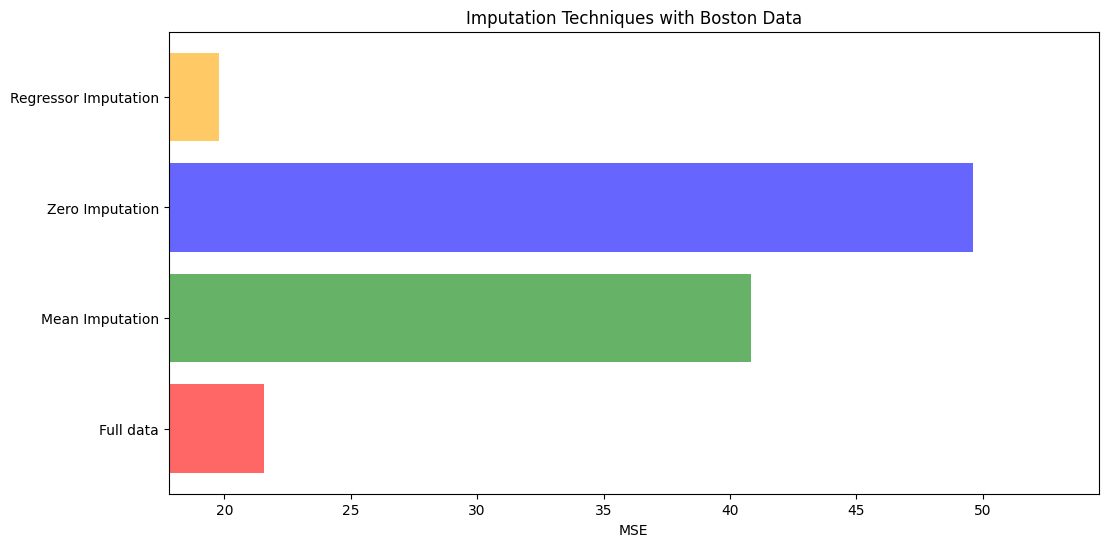

In [43]:
#画条形图
x_labels = ['Full data',
            'Mean Imputation',
            'Zero Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center')
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,
            right=np.max(mse) * 1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()

In [34]:
'''
用随机森林回归填补缺失值
从现实中收集的数据，几乎不可能是完美无缺的，往往都会有一些缺失值。面对缺失值，很多人选择的方式是直接将含有缺失值的样本删除，这是一种有效的方法，但是有时候填补缺失值会比直接丢弃样本效果更好，即便不知道缺失值的真实样貌。在sklearn中，可以使用sklearn.impute.SimpleImputer来轻松地将均值，中值，或者其他最常用的数值填补到数据中。
在下面这个案例中，将使用均值，0，和随机森林回归来填补缺失值，并验证在这几种状况下的拟合状况，找出对使用的数据集来说最佳的缺失值填补方法

使用随机森林填补缺失值：
任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地
区，环境，附近学校数量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。
对于一个有n个特征的数据来说，其中特征T有缺失值，就把特征T当作标签，其他的n-1个特征和原本的标签组成新的特征矩阵。T没有缺失的部分，就是Y_train，这部分数据既有标签也有特征，而它缺失的部分，只有特征没有标签，就是需要预测的部分。
即：
X_train：特征T不缺失的值对应的其他n-1个特征 + 本来的标签；
Y_train：特征T不缺失的值；
X_test：特征T缺失的值对应的其他n-1个特征 + 本来的标签；
Y_test：特征T缺失的，需要预测的未知值。
这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。
那如果数据中除了特征T之外，其他特征也有缺失值怎么办？
答案是：遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。
填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。
遍历所有的特征后，数据就完整，不再有缺失值了。
'''
#可见，用均值、0、随机森林回归来填补缺失值，随机森林预测的拟合效果最好。

'\n用随机森林回归填补缺失值\n从现实中收集的数据，几乎不可能是完美无缺的，往往都会有一些缺失值。面对缺失值，很多人选择的方式是直接将含有缺失值的样本删除，这是一种有效的方法，但是有时候填补缺失值会比直接丢弃样本效果更好，即便不知道缺失值的真实样貌。在sklearn中，可以使用sklearn.impute.SimpleImputer来轻松地将均值，中值，或者其他最常用的数值填补到数据中。\n在下面这个案例中，将使用均值，0，和随机森林回归来填补缺失值，并验证在这几种状况下的拟合状况，找出对使用的数据集来说最佳的缺失值填补方法\n\n使用随机森林填补缺失值：\n任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地\n区，环境，附近学校数量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。\n对于一个有n个特征的数据来说，其中特征T有缺失值，就把特征T当作标签，其他的n-1个特征和原本的标签组成新的特征矩阵。T没有缺失的部分，就是Y_train，这部分数据既有标签也有特征，而它缺失的部分，只有特征没有标签，就是需要预测的部分。\n即：\nX_train：特征T不缺失的值对应的其他n-1个特征 + 本来的标签；\nY_train：特征T不缺失的值；\nX_test：特征T缺失的值对应的其他n-1个特征 + 本来的标签；\nY_test：特征T缺失的，需要预测的未知值。\n这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。\n那如果数据中除了特征T之外，其他特征也有缺失值怎么办？\n答案是：遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。\n填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特